In [2]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('fivethirtyeight')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

# Project 1: Income vs. Home Prices over time in San Francisco, California

According to an [LMKJournal article](https://lbmjournal.com/home-prices-are-rising-2x-faster-than-income/#:~:text=Home%20Prices%20Have%20Grown%202x%20Faster%20Than%20Income%20Since%202000&text=Between%201985%20and%202022%20%E2%80%94%20the,household%20income%20rose%20just%20216%25), home prices have been surging 2 times faster than income since the early 2000s. "Between 1985 and 2022, the median home sale price in the U.S. climbed 423%, while median household income rose just 216%." This concerning discrepancy suggests that homes value growth have been outpacing income, driving up prices and exerting financial pressures for families whose wages struggles to keep up. 

For the topic of this project, San Francisco is a unique city with diverse neighborhoods. It is not uncommon for an expensive neighborhood to be separated from a dangerous one by a mere city block. This [article by SF Chronicle](https://www.sfchronicle.com/projects/real-estate/bay-area-home-prices/) states that "In a Feb. 2022 report, the National Association of Realtors found that for every 1,206 households earning about the median income in San Francisco and San Jose, only one home in their price bracket was on the market". This shows that San Francisco is facing the same housing vs. income problem. However, San Francisco's situation is different because of the wide and diverse range of neighborhoods.

This project will explore the relationship income has with home prices in San Francisco as a whole, as well as specific neighborhoods (categorized by zip codes). San Francisco has a experienced a tech boom over the past decade, making it one of the best cities to work in for those in the tech industry. This project hypothesizes that as a byproduct of the shift in San Francisco's workforce direction and its growing popularity, housing values are escalated as more workers moved to the city. This could mean that housing markets are beginning to become more competitive, as well as gentrifying lower-income neighborhoods as a byproduct of their homes beginning to be inhabited by higher-wage earners.

This project hopes to show gentrification in lower-income neighborhoods by comparing their median income and home values over the past decade, and demonstrating that despite San Francisco showing a synchronized growth in income and home values, lower-income communities are struggling to keep up. 

# Data Sources 

Data for this project are taken from multiple sources:

1. [U.S. Census Bureau](https://data.census.gov/) - This will be the primarily source for most of the data obtained in the project. Due to the fact that it is a government funded project and its credibility are widely known already, it will be a safe source to sample from.

2. [DATA USA](https://datausa.io/profile/geo/san-francisco-ca) - A project that sourced its data from the U.S. Census, it will be primarily be used as a quicker access to cleaned data from the Census.

3. [Neighborhood Scout](https://www.neighborhoodscout.com/ca/san-francisco/crime) - This source will provide identifications on what neighborhoods are considered high crime and/or low income. It sources directly from local enforcement authorities and originally released by the FBI.

# Income

The project will first look at San Francisco's income overtime (2013-2021) with data from [DATA USA](https://datausa.io/profile/geo/san-francisco-ca#income-by-location).  

However, Since this table has unnecessary entries and columns such as "Slug Geography" and "ID Geography", the table will be simplified with only the relevant data.

In [3]:
income = Table.read_table('Household Income.csv')
income_sim = income.drop("Slug Geography", "ID Household Income Bucket", "Year", "ID Geography", "Household Income Moe").where("Geography", are.equal_to("San Francisco, CA")).relabel("Household Income", "Households")
income_sim

Household Income Bucket,ID Year,Households,Geography,share
"< $10,000",2021,16285,"San Francisco, CA",0.0450831
"$10,000-$14,999",2021,16864,"San Francisco, CA",0.046686
"$15,000-$19,999",2021,8806,"San Francisco, CA",0.0243784
"$20,000-$24,999",2021,9052,"San Francisco, CA",0.0250594
"$25,000-$29,999",2021,9441,"San Francisco, CA",0.0261363
"$30,000-$34,999",2021,6781,"San Francisco, CA",0.0187724
"$35,000-$39,999",2021,7490,"San Francisco, CA",0.0207352
"$40,000-$44,999",2021,7246,"San Francisco, CA",0.0200597
"$45,000-$49,999",2021,6890,"San Francisco, CA",0.0190741
"$50,000-$59,999",2021,13756,"San Francisco, CA",0.0380818


A function will be created to find the average income of each year and a table will be made with 2 columns "Year" and "Average Income" to store this data.

In [4]:
#Since 10,000 has no lower boundary and 200,000k+ income bracket has no upper boundary, an estimation will be used for the array.
income_bucket = make_array(5000, 12500, 17500, 22500, 27500, 32500, 37500, 42500, 47500, 55000, 67500, 87500, 112500, 137500, 175000, 300000)

#Function that takes in an integer 'a' which are limited to the range of 2013-2021 inclusive. It will then find the column of ID Year where
#the year is the same as the input, and then iterates through Households of that year. It will multiply the array income_bucket with
#the number of Households and finally divided by the sum of all Households from that year to find the average.
def find_average_income(a):
    households = income_sim.where("ID Year", are.equal_to(a)).column("Households")
    income_of_year = np.sum(households * income_bucket) / np.sum(households)
    return income_of_year

array_average = income_sim.group("ID Year").apply(find_average_income, "ID Year")

income_average = Table().with_column("Year", income_sim.group("ID Year").column("ID Year")).with_column("Average Income", array_average)
income_average

Year,Average Income
2013,104453
2014,107498
2015,111369
2016,117679
2017,125635
2018,133687
2019,141400
2020,146322
2021,151978


However, as this dataset from DATA USA does not have prearranged median values and a lack of an upper boundary at 200,000+ income, it can potentially cost issues with accuracy. So, data will instead be imported from the [U.S. Census Bureau](https://data.census.gov/table?t=Income%20(Households,%20Families,%20Individuals)&g=050XX00US06075&y=2022) with existing values. 

Since the Census data is not congregated into a single dataset, it is inefficient to import 13 cvs files. So, an array will be made instead from the manually imported data. Furthermore, since top earners might skew the average and obfuscate the results, the median of income will be taken instead.

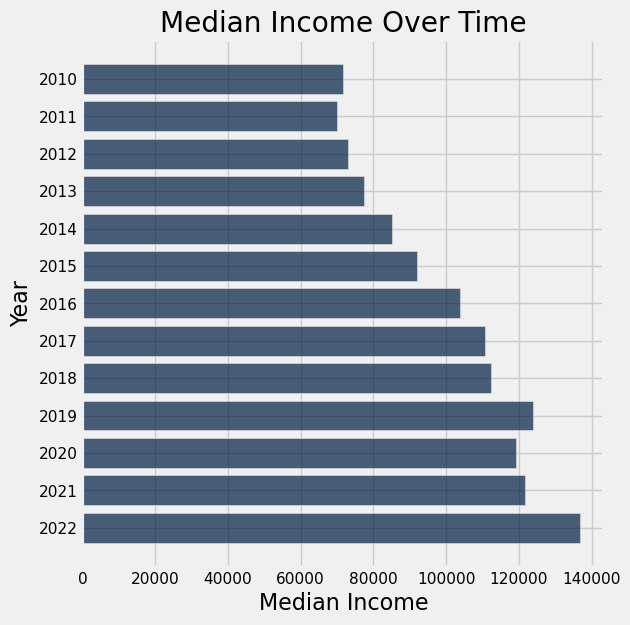

In [22]:
years_census = np.arange(2010, 2023)
income_census = make_array(71745, 69894, 73012, 77485, 85070, 92094, 103801, 110816, 112376, 123859, 119136, 121826, 136692)
table_income_census = Table().with_column("Year", years_census).with_column("Median Income", income_census)     

table_income_census.barh("Year")
plt.title("Median Income Over Time")
plt.xlabel("Median Income")
plt.show()

The bar graph shows a growth from year to year since 2011, and the decline in 2020 and 2021 is probably due to Covid-19 lockdown. It is also worth noting that median wage is at an all time high in 2022 when compared to the other years in the graph. 

# Home Values in San Francisco

With income sorted into a table, home values will now be imported into the project. Since the home value data faces the same problem as DATA USA, median home values will be manually imported from [U.S. Census Bureau](https://data.census.gov/table/ACSST1Y2022.S2506?t=Housing%20Value%20and%20Purchase%20Price&g=050XX00US06075&y=2022) into an array.

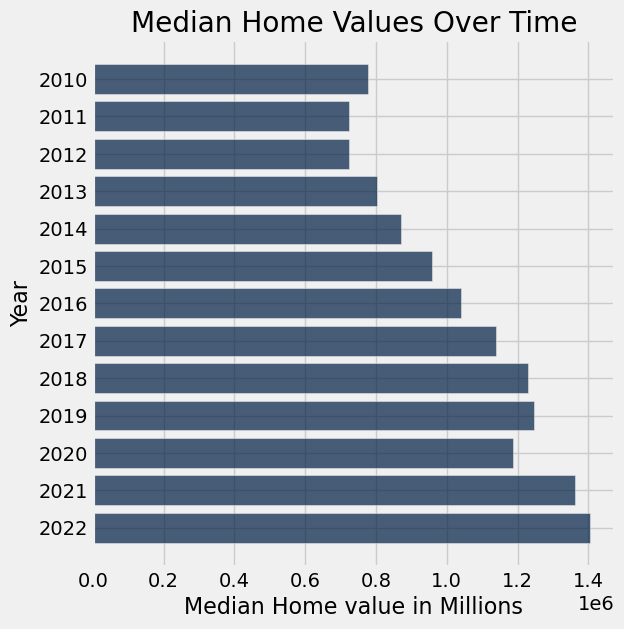

In [6]:
values_census = make_array(776900, 724600, 724500, 801500, 869600, 958400, 1040300, 1138400, 1230300, 1244900, 1185700, 1363400, 1404700)
table_values_census = Table().with_columns("Year", years_census, "Median Home Value", values_census)

table_values_census.barh("Year")
plt.title("Median Home Values Over Time")
plt.xlabel("Median Home value in Millions")
plt.show()

Median Home Value bar graph also shows an increase from year to year, except the brief downturn in 2020 most likely from Covid-19.

The following table will show the previous two tables joined together.

In [7]:
census_full = table_income_census.join("Year", table_values_census)
census_full.show()

Year,Median Income,Median Home Value
2010,71745,776900
2011,69894,724600
2012,73012,724500
2013,77485,801500
2014,85070,869600
2015,92094,958400
2016,103801,1040300
2017,110816,1138400
2018,112376,1230300
2019,123859,1244900


# Comparing Income vs Home Values

With both income and home values imported, their relationship will be graphed in the following sections. For the rest of the project, home values are assumed to be the market price if it's put on sale.

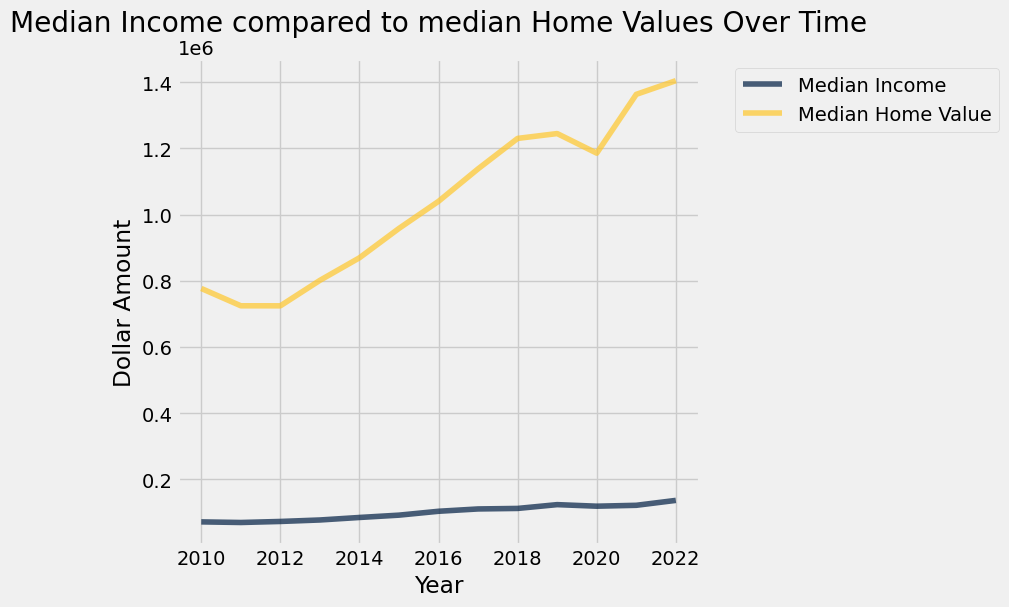

In [8]:
census_full.plot("Year")

plt.title("Median Income compared to median Home Values Over Time")
plt.ylabel("Dollar Amount")
plt.show()

The above graph does not give a lot of information as the difference in dollar amount is too huge to see changes in both categories. So, a percentage version of the graph will be used instead to see how income and home values changed over time. 

In [9]:
income_array = table_income_census.column("Median Income")
home_value_array = table_values_census.column("Median Home Value")

#Function that takes in an input of an array 'a', and then iterates through that array to find the percentage change from one index to the next. 
#Then it outputs an array 'income_of_year' that shows the change.
def find_percentage(a):
    percentage = []
    for i in np.arange(0, (len(a)-1)):
        percentage.append(((a[i+1] - a[i]) / a[i]) * 100)
    return percentage


years_str = np.array(years_census).astype('str').tolist()
years_for_percent = []

for i in np.arange(0, (len(years_str) - 1)):
    years_for_percent.append(years_str[i] + " to " + years_str[i+1])


comparison_percentage = Table().with_column("Year", years_for_percent)
comparison_percentage = comparison_percentage.with_column("Percentage Income Change", find_percentage(income_array))
comparison_percentage = comparison_percentage.with_column("Percentage Home Value Change", find_percentage(home_value_array))
comparison_percentage.show()

Year,Percentage Income Change,Percentage Home Value Change
2010 to 2011,-2.57997,-6.73188
2011 to 2012,4.46104,-0.0138007
2012 to 2013,6.12639,10.628
2013 to 2014,9.78899,8.49657
2014 to 2015,8.25673,10.2116
2015 to 2016,12.712,8.54549
2016 to 2017,6.75812,9.42997
2017 to 2018,1.40774,8.07273
2018 to 2019,10.2184,1.1867
2019 to 2020,-3.81321,-4.7554


This table will now be used to plot a line graph showing the relationship.

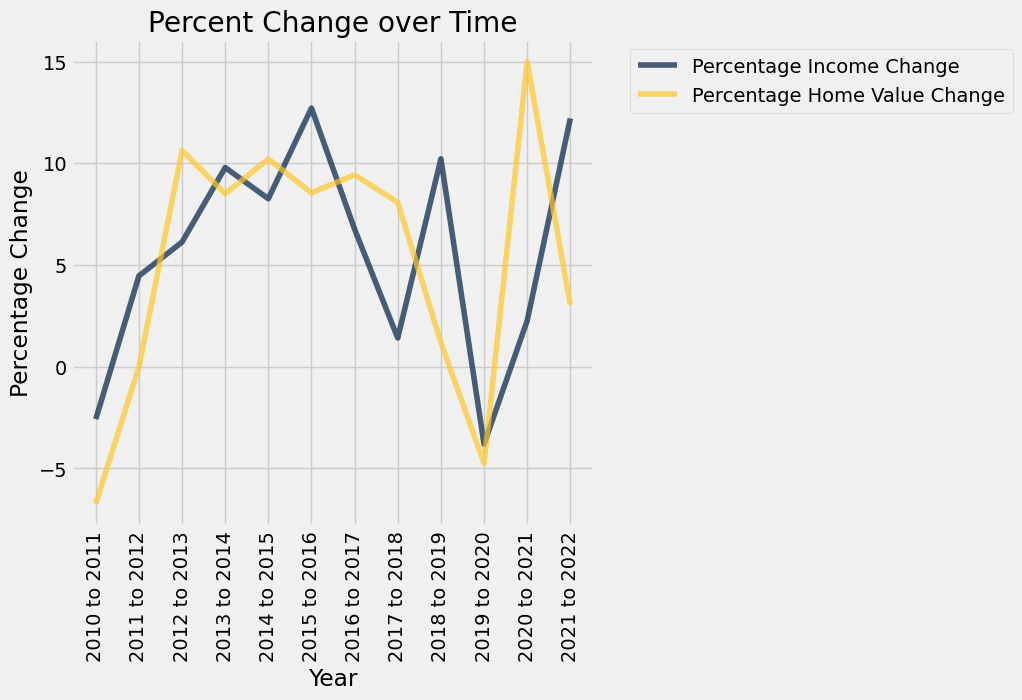

In [10]:
comparison_percentage.plot("Year")
plt.title("Percent Change over Time")
plt.ylabel("Percentage Change")
plt.xticks(rotation=90)
plt.show()

This graph above shows that macro-wise, percent of income change is relatively in-sync with percentage of home change value except a few special cases such as 2020 to 2021. That was when Covid-19 happened and the job market became stagnant, but home prices surged due to lower interest rates and housing shortages.([Source](https://www.bankrate.com/real-estate/covid-impact-on-the-housing-market/#market)).

The following graph will show the cumulative percent to better assess the relationship.

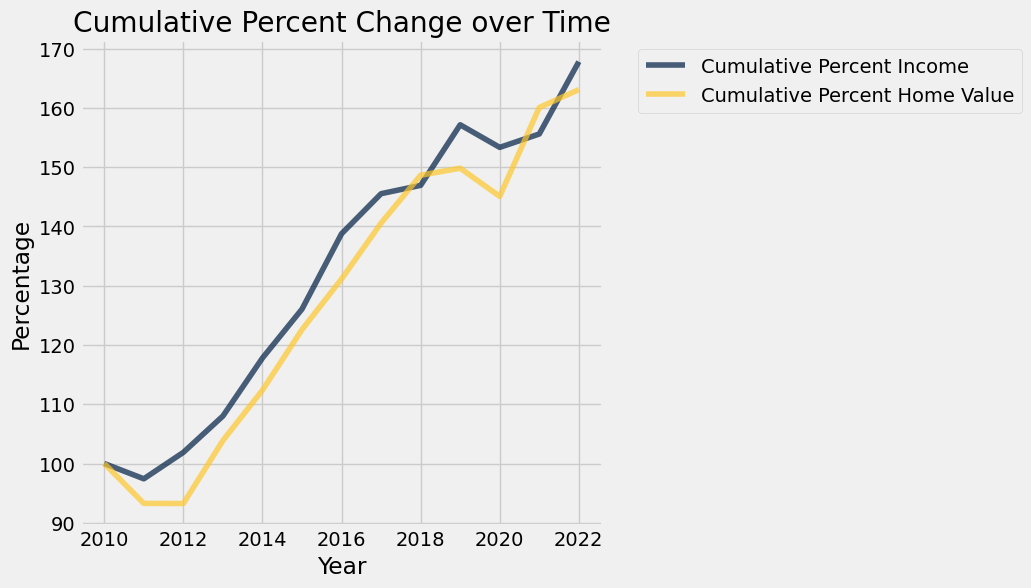

In [11]:
#Function that takes an input of an array 'a', and then iterates through that array by adding one index to the next and displaying it
#in percentage value. By the end, it will out array 'cumulative' that shows the cumulative percentage of each year beginning at 100% in 2010.
def cumulative_percent(a):
    cumulative = [100]
    cumulative.append(a[0] + 100)
    for i in np.arange(1, len(a)):
        cumulative.append(cumulative[i] + a[i])
    return cumulative

cumulative_percentage = Table().with_column("Year", years_census)
cumulative_percentage = cumulative_percentage.with_column("Cumulative Percent Income", cumulative_percent(comparison_percentage.column("Percentage Income Change")))
cumulative_percentage = cumulative_percentage.with_column("Cumulative Percent Home Value", cumulative_percent(comparison_percentage.column("Percentage Home Value Change")))

cumulative_percentage.plot("Year")

plt.title("Cumulative Percent Change over Time")
plt.ylabel("Percentage")
plt.show()

The above graph shows that income from 2010 to 2022 has a slightly higher percentage increase over the years before being overtaken briefly in 2021. But overall, it follows the growth of each other tightly.

The following graph will show on average, how many years it would take to buy a home with that year's median income if it is all spent on a home. 

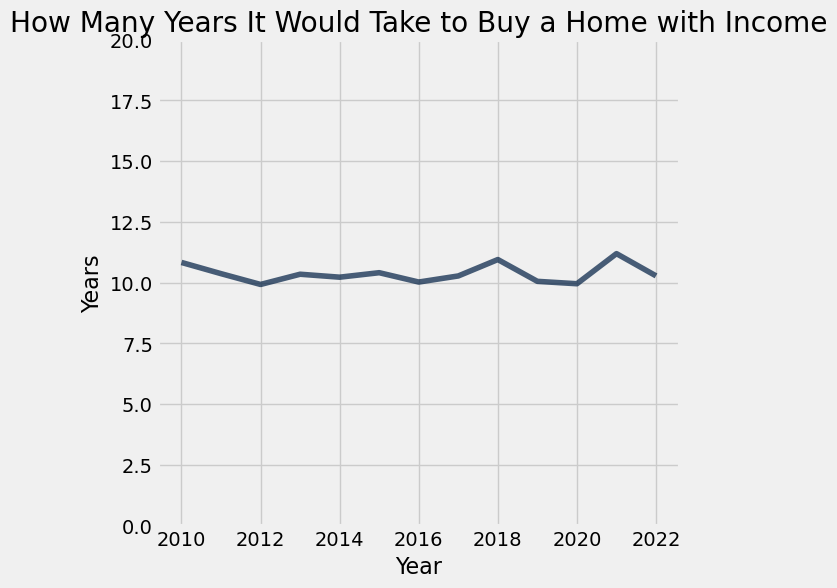

In [12]:
difference = (census_full.column("Median Home Value") / census_full.column("Median Income"))
difference_table = census_full.select("Year").with_column("Difference", difference)
difference_table.plot("Year")

plt.title("How Many Years It Would Take to Buy a Home with Income")
plt.ylabel("Years")
plt.ylim(bottom=0, top=20)
plt.show()

The years it would take is relatively flat and shows that San Francisco has an almost linear relationship with income and home values. This is an interesting comparison with some of the articles this project referenced where home values have rocketed compared to income, but since San Francisco has seen explosive growth in interest from tech workers since [many large tech companies are in the city](https://missywinssf.com/blog/10-reasons-san-francisco-is-a-tech-hub). Income in San Francisco began to rise as [6-digit salary from working in tech became the norm in the city](https://www.bbc.com/news/world-us-canada-44725026). With this rise, home values followed suit, but it is worth noting that San Francisco is a small city with very diverse neighborhoods in terms of financial prosperity. This begs further investigation into the inner workings of the city, and neighborhood data will be a way to see if income really has been on par with the growth of home values or has it been overshadowed by the higher earners and lower-income communities are suffering from the consequences of inflated housing prices.

# Zip Codes, Neighborhoods, and its Significance 

Since the project established San Francisco as a unique city with a diverse neighborhood with varying income and home values, it is imperative that we dive deeper into the different zip codes to see the relationship between them and see if it backs up with the claim that low-income neighborhoods are struggling to keep up with the growth in home values. The following zip codes are compiled for its significant traits of being either popular, high cost of living, or high crime rate neighborhoods. Its categorical groupings are sourced from [Neighborhood Scout](https://www.neighborhoodscout.com/ca/san-francisco/crime).

In [13]:
zipcode_desc = Table.read_table('Zipcode Data 1.csv')
zipcode_desc.show()

Zip Codes,Area,Trait
94102,Tenderloin,Considered high crime according to the DA office.
94103,Soma/Mission/Downtown,Downtown/central San Francisco/one of the highest crime ...
94105,Union Square/Academy of Art University,Downtown/High crime rate/Also neighboring one of the ric ...
94112,Mission,Considered high crime according to the DA office.
94121,Seacliff,One of the most expensive areas in San Francisco
94122,Sunset/Golden Gate Park,One of the more popular zip codes to live in.
94124,Bayview,Considered high crime according to the DA office.
94127,St Francis Wood,One of the most expensive areas in San Francisco
94133,Telegraph Hill,High crime rate
94134,McLaren Park / South McLaren Park,South of Mclaren Park is one of the safest areas in San ...


Since the [Income](https://data.census.gov/table?t=Income%20(Households,%20Families,%20Individuals)&g=860XX00US94134&y=2022) and [Home Values](https://data.census.gov/table?t=Housing%20Value%20and%20Purchase%20Price&g=860XX00US94134&y=2022) are sorted into multiple different tables from the Census, it is inefficient to import 100+ tables for only a couple of relevant entries from each one. So, the following data table is manually compiled from U.S. Census Bureau and imported as a CVS file. 

In [14]:
zipcode = Table.read_table('Zipcode Data 2.csv')
zip_code_array = zipcode.column("Zip Code")
zip_code_year = zipcode.group("Year").column("Year")
zipcode

Year,Income,Home,Zip Code
2011,22159,562300,94102
2011,42801,660400,94103
2011,120257,743100,94105
2011,72467,633600,94112
2011,77612,886700,94121
2011,79441,794700,94122
2011,46025,545300,94124
2011,138003,977400,94127
2011,50378,904900,94133
2011,57075,581000,94134


The following table will use the zipcode table and look at the lowest income in 2011 and 2022 across all unique zip codes.

In [15]:
zipcode_lowest_2011 = zipcode.sort("Income").where("Year", are.equal_to(2011)).take(0)

zipcode_lowest_in_2022 = zipcode.where("Zip Code", are.equal_to(zipcode_lowest_2011.column("Zip Code")[0])).where("Year", are.equal_to(2022))

zipcode_lowest_2011.show()
zipcode_lowest_in_2022.show()
print(f'It would take 94102 {zipcode_lowest_2011.column("Home") / zipcode_lowest_2011.column("Income")} years to buy a home in 2011.')
print(f'It would take 94102 {zipcode_lowest_in_2022.column("Home") / zipcode_lowest_in_2022.column("Income")} years to buy a home in 2022.')

Year,Income,Home,Zip Code
2011,22159,562300,94102


Year,Income,Home,Zip Code
2022,62388,1051100,94102


It would take 94102 [ 25.37569385] years to buy a home in 2011.
It would take 94102 [ 16.84779124] years to buy a home in 2022.


From the above table, the lowest income neighborhood in both 2011 and 2022 is in 94102, the Tenderloin, which is considered one of the worst neighborhoods in San Francisco according to Neighborhood Scout. From these two years, it shows that it takes on average 25.376 years to purchase a home with 2011 income and it would take 16.848 years in 2022. This shows a decrease meaning it's more accessible for those making median income to purchase a home, which is a good thing. However, there are a lot of other variables at play, such as the [recent influx of higher wage earners that moved to San Francisco for better job perspectives](https://www.theguardian.com/us-news/2015/jul/20/san-francisco-tenderloin-district-gentrification-tech-companies) that might skew the median of income. These variables will be further explored in the later sections. 

Since the project is establishing 94102 as one of the key neighborhoods to analyze, the following table will show the zip code 94102 with home values that are similar in 2011 and 2022.

In [16]:
zipcode_94102_2011 = zipcode.where("Year", are.equal_to(2011)).where("Home", are.between(500000, 600000))
zipcode_94102_2022 = zipcode.where("Year", are.equal_to(2022)).where("Home", are.between(1000000, 1100000))
zipcode_94102_2011.show()
zipcode_94102_2022.show()

Year,Income,Home,Zip Code
2011,22159,562300,94102
2011,46025,545300,94124
2011,57075,581000,94134


Year,Income,Home,Zip Code
2022,62388,1051100,94102
2022,111028,1051200,94103
2022,76341,1011500,94124
2022,104247,1051800,94134


The table shows that in 2011, while 94102 has the lowest income at 22159, its housing prices are at a similar level compared to neighborhoods that make more than 2 times 94102's income. The second table also shows that while all of the home values are around the same median price at 1 million, 94102's yearly income is still significantly less than some of the other zip codes in the table. This shows that while income and home seemed to be in tandem as it grew over the years, low income neighborhoods such as 94102 are not growing at the same pace as the city data would have suggested. Gentrification of low-income neighborhoods from workers moving to San Francisco for a better job prospective might be the cause. As San Francisco housing grew over the years, people moving into the city are struggling to find housing that are not overtly expensive and they could have settled for the Tenderloin due to its low prices. This also begs the question that how inflated is the median income in Tenderloin if home values are on par with neighborhoods that make 40% more yearly.  There could be many income outliers in Tenderloin with average San Francisco income but the original community's wages dragged the median down, this could mean that the median wages could be even lower if not accounting for these outliers. Another possibility is that realtors and investors are buying up homes in San Francisco and driving up prices everywhere, most heavily impacting lower-income neighborhoods.

The table below shows the comparison between the lowest income and highest income in 2011 and 2022.

In [17]:
zipcode_high_and_low_2011 = zipcode.sort("Income").where("Year", are.equal_to(2011)).take(0, -1)
zipcode_high_and_low_2022 = zipcode.sort("Income").where("Year", are.equal_to(2022)).take(0, -1)

zipcode_high_and_low_2011.show()
zipcode_high_and_low_2022.show()
print(f'It would take 94012 {zipcode_high_and_low_2011.column("Home")[0] / zipcode_high_and_low_2011.column("Income")[0]} years to buy a home in 2011, and would only take {zipcode_high_and_low_2011.column("Home")[-1] / zipcode_high_and_low_2011.column("Income")[-1]} years for 94127')
print(f'It would take 94012 {zipcode_high_and_low_2022.column("Home")[0] / zipcode_high_and_low_2022.column("Income")[0]} years to buy a home in 2022, and would only take {zipcode_high_and_low_2022.column("Home")[-1] / zipcode_high_and_low_2022.column("Income")[-1]} years for 94127')
print(f'The difference in income between 94102 and 94105 is {(zipcode_high_and_low_2022.column("Income")[-1] / zipcode_high_and_low_2022.column("Income")[0]) * 100}%, while the difference in home value is only {(zipcode_high_and_low_2022.column("Home")[-1] / zipcode_high_and_low_2022.column("Home")[0]) * 100}%')

Year,Income,Home,Zip Code
2011,22159,562300,94102
2011,138003,977400,94127


Year,Income,Home,Zip Code
2022,62388,1051100,94102
2022,270000,1434800,94105


It would take 94012 25.375693849000406 years to buy a home in 2011, and would only take 7.082454729245017 years for 94127
It would take 94012 16.847791241905494 years to buy a home in 2022, and would only take 5.314074074074074 years for 94127
The difference in income between 94102 and 94105 is 432.77553375649165%, while the difference in home value is only 136.5046142136809%


While it is not ideal to compare neighborhoods on both extreme ends of the spectrum, the relationship from these zip codes provide important insights on the wage gap between the low and high earners. In the year 2011, it would on average take 94102 25.375 years to afford a home with their income but it would only take 94127 (Saint Francis Wood, one of the most expensive neighborhoods in San Francisco) around 7.082 years to afford a home. In 2022, it would take 94102 16.847 years and it would only take 94105 (The Financial District and Downtown) 5.31 years. The gap, despite the high income neighborhoods having more expensive homes, is still huge compared to the lower income neighborhoods. In 2022, the difference between the lowest and highest income is roughly 432% but the difference between the home value is only 136%. This shows that while 94105 has almost 4 times the median income, its homes are only around 1.36 times more expensive, which demonstrates a huge disparity between the affordability of homes in lower income neighborhoods such as 94102. 

However, since the years to own a home variable is calculated on the basis that ALL of the yearly income went towards buying a home, it does not account for higher income households that might have disposable income. So this table is only a comparison on its original basis, but it still serves the purpose of demonstrating a severe financial difference in these neighborhoods and brings attention to lower-income neighborhoods being more susceptible to the growth trajectory of San Francisco homes.

The following sections graph median income and median home value over time.

In [18]:
zipcode_income = Table().with_column("Year", zip_code_year)

for i in np.arange(len(zip_code_array)):
    income_array = zipcode.where("Zip Code", are.equal_to(zip_code_array[i])).column("Income")
    zipcode_income = zipcode_income.with_column(f'{zip_code_array[i]}', income_array)

#A function to plot an interactive graph for the zipcode_income table, with an input for the widget to specify year. It will take that input
#and take the relevant rows from the table and output a graph.
def time_income(year):
    year_range = len(np.arange(2011, year+1))
    graph = zipcode_income.take(np.arange(year_range))
    x = graph.column("Year")
    graph.plot("Year")
    xticks = np.arange(min(x), max(x) + 1)
    plt.xticks(xticks)
    plt.rc('xtick', labelsize=11)
    plt.rc('ytick', labelsize=11)
    plt.title("Median Income Over Time")
    plt.ylabel("Income in Dollars")


widgets.interact(time_income, year=(2012, 2022, 1))
plt.show()

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

The graph above shows the growth of median income, and it seems that every zip code has a positive trend over the years. With a few outliers that has more abrupt increase such as 94105 (The Financial District). 

The following graph will show the trend of median home values over the years.

In [19]:
zipcode_home = Table().with_column("Year", zip_code_year)

for i in np.arange(len(zip_code_array)):
    home_array = zipcode.where("Zip Code", are.equal_to(zip_code_array[i])).column("Home")
    zipcode_home = zipcode_home.with_column(f'{zip_code_array[i]}', home_array)
    
#A function to plot an interactive graph for the zipcode_home table, with an input for the widget to specify year. It will take that input
#and take the relevant rows from the table and output a graph.
def time_home(year):
    year_range = len(np.arange(2011, year+1))
    graph = zipcode_home.take(np.arange(year_range))
    x = graph.column("Year")
    graph.plot("Year")
    xticks = np.arange(min(x), max(x) + 1)
    plt.xticks(xticks)
    plt.title("Median Home Value Over Time")
    plt.ylabel("Home Value in Millions")

widgets.interact(time_home, year=(2012, 2022, 1))
plt.show()

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

The graph shows a general upward trend in-sync with median income. There are a couple outliers such as 94105 and 94102 between 2020 and 2022 that could be the result of neighborhoods that are hit by Covid-19 the hardest (financial sectors and small business owners relying on foot traffic) before lower interest rates are introduced. 

# How Many Years It Would Take to Buy a Home

After seeing the trends, the following section will explore the relationship between the two graphs by finding how many years it would take to buy a home over the years for each zip code. 

In [20]:
#A function for finding the years by taking in an int 'a' which is a zip code, and then it filters out the original zipcode table to find only the rows 
#that are in the zipcode 'a'. Then it takes the column array of Home and divide it by the column array of Income to find how many years it would to
#buy a home in that year for that zipcode. It will then output the array of years it will take.
def find_years(a):
    temp_zip = zipcode.where("Zip Code", are.equal_to(a))
    difference = (temp_zip.column("Home") / temp_zip.column("Income")) 
    return difference

zip_code_difference = Table().with_column("Year", zip_code_year)

for i in np.arange(len(zip_code_array)):
    temp_difference = find_years(zip_code_array[i])
    zip_code_difference = zip_code_difference.with_column(f'{zip_code_array[i]}', temp_difference)

#A function to plot an interactive graph for the zip_code_difference table, with an input for the widget to specify year. It will take that input
#and take the relevant rows from the table and output a graph.
def time_how_many_years(year):
    year_range = len(np.arange(2011, year+1))
    graph = zip_code_difference.take(np.arange(year_range))
    x = graph.column("Year")
    graph.plot("Year")
    xticks = np.arange(min(x), max(x) + 1)
    plt.xticks(xticks)
    plt.title("How Many Years It Would Take to Buy a Home with Income")
    plt.ylabel("Years")

widgets.interact(time_how_many_years, year=(2012, 2022, 1))
plt.show()

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

From this graph above, the neighborhood that showed an increase are 94124, 94127, 94112, and 94133. These 4 zip codes alongside with 94102 will be further examined in the following sections. By pulling up the description of the zip code again, we will get a better sense of the general neighborhood traits

In [21]:
zipcode_desc

Zip Codes,Area,Trait
94102,Tenderloin,Considered high crime according to the DA office.
94103,Soma/Mission/Downtown,Downtown/central San Francisco/one of the highest crime ...
94105,Union Square/Academy of Art University,Downtown/High crime rate/Also neighboring one of the ric ...
94112,Mission,Considered high crime according to the DA office.
94121,Seacliff,One of the most expensive areas in San Francisco
94122,Sunset/Golden Gate Park,One of the more popular zip codes to live in.
94124,Bayview,Considered high crime according to the DA office.
94127,St Francis Wood,One of the most expensive areas in San Francisco
94133,Telegraph Hill,High crime rate
94134,McLaren Park / South McLaren Park,South of Mclaren Park is one of the safest areas in San ...


94124, 94127, and 94133 are Bayview, Saint Francis Wood, and Telegraph Hill respectively. 94124 and 94133 both identifies as high crime rate areas, while Saint Francis Wood maintained a heavy growth because owners in those neighborhoods are so satisfied with the area that they if they move, they still chose to [upgrade to a bigger house in the same area](https://www.sfchronicle.com/realestate/article/sf-expensive-homes-17489955.php). This leaves Bayview and Telegraph Hill, which coupled with 94012 (the Tenderloin), makes it all 4 of the high crime rate zip codes according to the traits in the table. This means that it has gotten longer for people in this neighborhood to able to afford a home compared to all the other zip codes where the length stayed relatively the same [except 90103, which is an example of gentrification in lower income neighborhoods in San Francisco](https://48hills.org/2021/10/luxury-housing-will-destroy-the-last-low-income-community-in-soma/). The SOMA district (94103) has many original residents pushed out because of the rising home values that steeply contradict their wages, and as many higher-earners move in, the years to own homes shifted dramatically. This might eventually happen to neighborhoods such as 94012, 94124, 94127, and 94133 as the y-value increase over the years before finally giving in and dropping to adhere with the average of the other zip codes due to gentrification. 94102 is an interesting case as mentioned in previous sections where higher earners are moving into their neighborhood and raising home values, and since the y-value was already massive compared to the others since the beginning, it began to drop. 

This graph and the analysis shows that despite a positive increase for both income and median when we look at San Francisco as a whole, years needed to own a house are rising for lower-income neighborhoods. These neighborhoods are often overlooked in analysis of San Francisco income and housing trajectory, it also doesn't help that their data does not make a significant difference in the macro data. This is likely very dangerous for the communities in these zip codes as neighborhoods like 94012 are already in the process of being gentrified, while other neighborhoods are in the beginning phases where gentrification hasn't came but housing prices are already rising faster than income such as 94124, 94127, and 94133. 

To summarize, while the data for San Francisco as a city show income rising in tandem with home values, lower-income neighborhoods are struggling to keep up with the pace, with some neighborhoods already becoming too expensive for its original communities. Their data not being showed on big data graphs highlight the danger they are in as their communities slowly and silently get swallowed up and pushed out because of the ever-growing disparity between their income and home prices. 

# Reflection

When I first started the project, I began with research into areas that I was interested in. Some of the topics I came up with was "Costs compared to satisfaction of living in relation to minimum wage in San Francisco", "Housing market in San Francisco compared to other popular cities", and "Income vs. Home Prices over time in San Francisco, California", to which I chose the latter. As I began formulating my project around my chosen topic, I gathered some articles that seemed to propose that housing prices have been rising faster than income, and I formed my thesis around that. However, as I began compiling data for San Francisco as a whole, I found that the housing and income trends are not rising disproportionately against each other, which went against what I initially based this project on. This was one of the issues I faced as I should have formulated a thesis better and conducted more thorough research before committing to it. So, I began looking at smaller data like specific zip codes and I was able to compiled a good amount that has specific traits like crime rate. With a new change in thesis, I made various graphs for the different zip codes and it was one of the successes I had where I was able to demonstrate my hypothesis from the results. Another success that I have had was that I didn't have many troubles with importing data and with the code except trying to make more interactive graphs and animations. A follow up to the project that I started could be incorporating more zip codes, separating zip codes by more categories such as crime rate, age, race, etc, as well as finishing animated and interactive maps that would demonstrate San Francisco divided by neighborhoods and the color of these neighborhoods change based on the data over time. Another follow up could be researching job sectors of these zip codes to show what percentage tech or higher wage workers make up a neighborhood, as well as their income vs the local's income. I believe this would further strengthen the thesis of the project. 